# 実践編: ディープラーニングを使ったモニタリングデータの時系列解析

健康意識の高まりや運動人口の増加に伴って，活動量計などのウェアラブルデバイスが普及し始めています．センサーデバイスから心拍数などの情報を取得することで，リアルタイムに健康状態をモニタリング可能なため，近年ではヘルスケア分野でも活用事例が増えてきています．例えば最近，Cardiogram社とカリフォルニア大学の共同研究で，心拍データから糖尿病予備群を予測する研究論文(DeepHeart)が報告され，注目を集めました．また，Apple Watch Series 4には心電図作成の機能が搭載されるなど，センサーデバイスも進歩してきています．従って，こうしたモニタリングデータを収集・解析し，健康管理に繋げていく取り組みは今後益々盛んになっていくと考えられます．

本章では，心電図(ECG)の波形データを対象として，不整脈か否かを予測する問題に取り組みます．

## 目次

1. 環境構築
1. 使用するデータセット
1. データ前処理
1. DLを用いた時系列データ解析
1. 精度向上に向けて
  1. クラス不均衡データへの対応
    1. Undersampling & Oversampling
    1. 損失関数
  1. ネットワーク構造
  1. ノイズ除去の効果検証

## 環境構築

はじめに, 下記の必要ライブラリをインストールします.

* Cupy
* Chainer
* Scipy
* Matplotlib
* Seaborn
* Pandas
* WFDB
* Scikit-learn
* Imbalanced-learn

以下のセルを実行 (Shift + Enter) して下さい. 

In [1]:
!set -ex
!apt -y -q install cuda-libraries-dev-9-2
!pip install cupy-cuda92==5.0.0
!pip install chainer==5.0.0
!pip install scipy==0.19.1 matplotlib==2.1.2 seaborn==0.7.1 pandas==0.22.0 wfdb==2.2.1
!pip install imbalanced-learn==0.4.3

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  cuda-cublas-dev-9-2 cuda-cufft-dev-9-2 cuda-curand-dev-9-2
  cuda-cusolver-dev-9-2 cuda-cusparse-dev-9-2 cuda-npp-dev-9-2
  cuda-nvgraph-dev-9-2 cuda-nvrtc-dev-9-2
The following NEW packages will be installed:
  cuda-cublas-dev-9-2 cuda-cufft-dev-9-2 cuda-curand-dev-9-2
  cuda-cusolver-dev-9-2 cuda-cusparse-dev-9-2 cuda-libraries-dev-9-2
  cuda-npp-dev-9-2 cuda-nvgraph-dev-9-2 cuda-nvrtc-dev-9-2
0 upgraded, 9 newly installed, 0 to remove and 5 not upgraded.
Need to get 332 MB of archives.
After this operation, 972 MB of additional disk space will be used.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1710/x86_64  cuda-cublas-dev-9-2 9.2.148.1-1 [50.4 MB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1710/x86_64  cuda-cufft-dev-9-2 9.2.148-1 [106 MB]
Get:3 https://developer.download.nvidia.com/compute/cuda/

インストールが完了したら, 以下のセルを実行して, 各ライブラリのインポート、及びバージョン確認を行って下さい.

In [2]:
import os
import random
import numpy as np
import cupy
import chainer
import scipy
import pandas as pd
import matplotlib
import seaborn as sn
import wfdb
import sklearn
import imblearn

chainer.print_runtime_info()
print("Scipy: ", scipy.__version__)
print("Pandas: ", pd.__version__)
print("Matplotlib: ", matplotlib.__version__)
print("Seaborn: ", sn.__version__)
print("WFDB: ", wfdb.__version__)
print("Scikit-learn: ", sklearn.__version__)
print("Imbalanced-learn: ", imblearn.__version__)

Platform: Linux-4.14.65+-x86_64-with-Ubuntu-18.04-bionic
Chainer: 5.0.0
NumPy: 1.14.6
CuPy:
  CuPy Version          : 5.0.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 9020
  CUDA Driver Version   : 9020
  CUDA Runtime Version  : 9020
  cuDNN Build Version   : 7201
  cuDNN Version         : 7201
  NCCL Build Version    : 2213
iDeep: Not Available
Scipy:  1.1.0
Pandas:  0.22.0
Matplotlib:  2.1.2
Seaborn:  0.7.1
WFDB:  2.2.1
Scikit-learn:  0.20.0
Imbalanced-learn:  0.4.3


## 心電図(ECG)について

aa

## 使用するデータセット

ここでは，ECGの公開データとして有名な[MIT-BIH Arrhythmia Database (mitdb)](https://www.physionet.org/physiobank/database/mitdb/)を使用します．

mitdbには47名の患者から収集した，計48個のECGレコードが登録されており，各レコードファイルには約30分間の2種類(MLII，V1)の信号波形データが格納されています．また，各R波のピーク位置に対してアノテーションが付与されています．(データやアノテーションの詳細については[こちら](https://www.physionet.org/physiobank/database/html/mitdbdir/intro.htm)を御覧ください．)

mitdbはPhysioNetによって管理されており，ダウンロードや読み込み用のPythonパッケージが提供されているので，今回はそちらを利用します．

In [0]:
dataset_root = './'
download_dir = os.path.join(dataset_root, 'download')

まずはmitdbのデータをダウンロードしましょう．
※実行時にエラーが出た場合は，再度実行して下さい．

In [4]:
wfdb.dl_database('mitdb', dl_dir=download_dir)

Created local base download directory: ./download
Finished downloading files


ダウンロードに成功すると，`Finished downloading files`というメッセージが表示されます．

ファイル一覧を確認してみましょう．

In [5]:
print(sorted(os.listdir(download_dir)))

['100.atr', '100.dat', '100.hea', '101.atr', '101.dat', '101.hea', '102.atr', '102.dat', '102.hea', '103.atr', '103.dat', '103.hea', '104.atr', '104.dat', '104.hea', '105.atr', '105.dat', '105.hea', '106.atr', '106.dat', '106.hea', '107.atr', '107.dat', '107.hea', '108.atr', '108.dat', '108.hea', '109.atr', '109.dat', '109.hea', '111.atr', '111.dat', '111.hea', '112.atr', '112.dat', '112.hea', '113.atr', '113.dat', '113.hea', '114.atr', '114.dat', '114.hea', '115.atr', '115.dat', '115.hea', '116.atr', '116.dat', '116.hea', '117.atr', '117.dat', '117.hea', '118.atr', '118.dat', '118.hea', '119.atr', '119.dat', '119.hea', '121.atr', '121.dat', '121.hea', '122.atr', '122.dat', '122.hea', '123.atr', '123.dat', '123.hea', '124.atr', '124.dat', '124.hea', '200.atr', '200.dat', '200.hea', '201.atr', '201.dat', '201.hea', '202.atr', '202.dat', '202.hea', '203.atr', '203.dat', '203.hea', '205.atr', '205.dat', '205.hea', '207.atr', '207.dat', '207.hea', '208.atr', '208.dat', '208.hea', '209.atr'

ファイル名の数字はレコードIDを表しています．3種類のファイルがあり，それぞれ`.dat` : 信号波形ファイル，`.atr` : アノテーションファイル，`.hea` : 読み込みに必要なヘッダファイル，となっています．

次節では，これらのファイルを読み込んで，機械学習モデルの入出力に変換するためのデータ前処理方法について説明します．

## データ前処理

- TODO: 説明 - ベーシックな前処理として、以下の処理を行う


1. レコードIDを train/validation/testに分割
1. 波形ファイル(.dat) & アノテーションファイル(.atr)の読み込み (一部, 利用しないデータがある)
1. 10種以上の細分化されたラベルが付与されているが, 先行研究に従って3クラスに集約する
1. 波形データの正規化
1. 2秒間の部分波形(segment)に分割. 中央のピークに付与されているラベルを, その部分波形のラベルとして扱う

In [0]:
class BaseECGDatasetPreprocessor(object):

    def __init__(
            self,
            dataset_root='./',
            window_size=720,  # 2 seconds
    ):
        self.dataset_root = dataset_root
        self.download_dir = os.path.join(self.dataset_root, 'download')
        self.window_size = window_size
        self.sample_rate = 360.
        self.train_record_list = [
            '101', '106', '108', '109', '112', '115', '116', '118', '119', '122',
            '124', '201', '203', '205', '207', '208', '209', '215', '220', '223', '230'
        ]
        self.test_record_list = [
            '100', '103', '105', '111', '113', '117', '121', '123', '200', '210',
            '212', '213', '214', '219', '221', '222', '228', '231', '232', '233', '234'
        ]
        # annotation
        self.labels = ['N', 'V']
        self.valid_symbols = ['N', 'L', 'R', 'e', 'j', 'V', 'E']
        self.label_map = {
            'N': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',
            'V': 'V', 'E': 'V'
        }

    def load_data(
            self,
            base_record,
            channel=0  # [0, 1]
    ):
        record_name = os.path.join(self.download_dir, str(base_record))
        # read dat file
        signals, fields = wfdb.rdsamp(record_name)
        assert fields['fs'] == self.sample_rate
        # read annotation file
        annotation = wfdb.rdann(record_name, 'atr')
        symbols = annotation.symbol
        positions = annotation.sample
        return signals[:, channel], symbols, positions

    def normalize_signal(
            self,
            signal,
            method='std'
    ):
        if method == 'minmax':
            min_val = np.min(signal)
            max_val = np.max(signal)
            return (signal - min_val) / (max_val - min_val)
        elif method == 'std':
            signal -= np.mean(signal) / np.std(signal)
            return signal
        else:
            raise ValueError("Invalid value: {}".format(method))

    def create_data_slices(
            self,
            signal,
            symbols,
            positions
    ):
        X = []
        y = []
        sig_len = len(signal)
        for i in range(len(symbols)):
            start = positions[i] - self.window_size // 2
            end = positions[i] + self.window_size // 2
            if symbols[i] in self.valid_symbols and start >= 0 and end <= sig_len:
                segment = signal[start:end]
                assert len(segment) == self.window_size, "Invalid length"
                X.append(segment)
                y.append(self.labels.index(self.label_map[symbols[i]]))
        return np.array(X), np.array(y)

    def prepare_dataset(
            self,
            normalize=True
    ):
        if not os.path.isdir(self.download_dir):
            self.download_data()
        # prepare training dataset
        self._prepare_dataset_core(self.train_record_list, "train", normalize)
        # prepare test dataset
        self._prepare_dataset_core(self.test_record_list, "test", normalize)

    def _prepare_dataset_core(
            self,
            record_list,
            mode="train",
            normalize=True
    ):
        X, y = None, None
        for i in range(len(record_list)):
            signal, symbols, positions = self.load_data(record_list[i])
            if normalize:
                signal = self.normalize_signal(signal)
            if i == 0:
                X, y = self.create_data_slices(signal, symbols, positions)
            else:
                X_tmp, y_tmp = self.create_data_slices(signal, symbols, positions)
                X = np.vstack((X, X_tmp))
                y = np.concatenate((y, y_tmp))
        os.makedirs(os.path.join(self.dataset_root, mode), exist_ok=True)
        np.save(os.path.join(self.dataset_root, mode, "X.npy"), X)
        np.save(os.path.join(self.dataset_root, mode, "y.npy"), y)


- TODO: 説明 - prepare_dataset()を実行すると, train/validation/testデータに分割され, 対応するディレクトリ内に格納される

In [0]:
preprocessor = BaseECGDatasetPreprocessor(dataset_root)

In [0]:
preprocessor.prepare_dataset()

- TODO: 説明 - train/validation のデータの中身を確認する

In [0]:
X_train = np.load(os.path.join(dataset_root, 'train', 'X.npy'))
y_train = np.load(os.path.join(dataset_root, 'train', 'y.npy'))
X_test = np.load(os.path.join(dataset_root, 'test', 'X.npy'))
y_test = np.load(os.path.join(dataset_root, 'test', 'y.npy'))

In [10]:
print("X_train.shape = ", X_train.shape, "\ty_train.shape = ", y_train.shape)
print("X_test.shape = ", X_test.shape, "\ty_test.shape = ", y_test.shape)

X_train.shape =  (47738, 720) 	y_train.shape =  (47738,)
X_test.shape =  (45349, 720) 	y_test.shape =  (45349,)


In [11]:
uniq_train, counts_train = np.unique(y_train, return_counts=True)
print("y_train count each labels: ", dict(zip(uniq_train, counts_train)))

y_train count each labels:  {0: 43995, 1: 3743}


In [12]:
uniq_test, counts_test = np.unique(y_test, return_counts=True)
print("y_test count each labels: ", dict(zip(uniq_test, counts_test)))

y_test count each labels:  {0: 42149, 1: 3200}


- TODO: 説明 - 波形データを可視化してみる

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

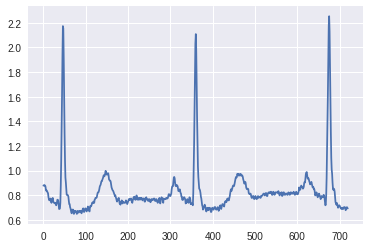

In [14]:
idx_n = np.where(y_train == 0)[0]
plt.plot(X_train[idx_n[0]])

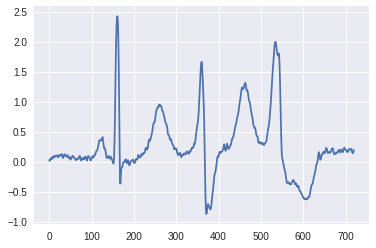

In [15]:
idx_s = np.where(y_train == 1)[0]
plt.plot(X_train[idx_s[0]])

## DLを用いた時系列データ解析

- TODO: 説明 - 3種類のクラス("N", "S", "V")を正しく識別するモデルを構築する

- TODO: 説明 - chainerデータセットクラス

In [0]:
class ECGDataset(chainer.dataset.DatasetMixin):

    def __init__(
            self,
            path
    ):
        if os.path.isfile(os.path.join(path, 'X.npy')):
            self.X = np.load(os.path.join(path, 'X.npy'))
        else:
            raise FileNotFoundError("{}/X.npy not found.".format(path))
        if os.path.isfile(os.path.join(path, 'y.npy')):
            self.y = np.load(os.path.join(path, 'y.npy'))
        else:
            raise FileNotFoundError("{}/y.npy not found.".format(path))

    def __len__(self):
        return len(self.X)

    def get_example(self, i):
        return self.X[None, i].astype(np.float32), self.y[i]


- TODO: 説明 - CNNモデル(ResNet構造)

In [0]:
import chainer.functions as F
import chainer.links as L
from chainer import reporter
from chainer import Variable
      
    
class BaseBlock(chainer.Chain):

    def __init__(
            self,
            channels,
            stride=1,
            dilate=1
    ):
        self.stride = stride
        super(BaseBlock, self).__init__()
        with self.init_scope():
            self.c1 = L.ConvolutionND(1, None, channels, 3, stride, dilate, dilate=dilate)
            self.c2 = L.ConvolutionND(1, None, channels, 3, 1, dilate, dilate=dilate)
            if stride > 1:
                self.cd  =L.ConvolutionND(1, None, channels, 1, stride, 0)
            self.b1 = L.BatchNormalization(channels)
            self.b2 = L.BatchNormalization(channels)

    def __call__(self, x):
        h = F.relu(self.b1(self.c1(x)))
        if self.stride > 1:
            res = self.cd(x)
        else:
            res = x
        h = res + self.b2(self.c2(h))
        return F.relu(h)


class ResBlockBase(chainer.Chain):

    def __init__(
            self,
            channels,
            n_block,
            dilate=1
    ):
        self.n_block = n_block
        super(ResBlockBase, self).__init__()
        with self.init_scope():
            self.b0 = BaseBlock(channels, 2, dilate)
            for i in range(1, n_block):
                bx = BaseBlock(channels, 1, dilate)
                setattr(self, 'b{}'.format(str(i)), bx)

    def __call__(self, x):
        h = self.b0(x)
        for i in range(1, self.n_block):
            h = getattr(self, 'b{}'.format(str(i)))(h)
        return h


class ResNet34(chainer.Chain):

    def __init__(self):
        super(ResNet34, self).__init__()
        with self.init_scope():
            self.conv1 = L.ConvolutionND(1, None, 64, 7, 2, 3)
            self.bn1 = L.BatchNormalization(64)
            self.resblock0 = ResBlockBase(64, 3)
            self.resblock1 = ResBlockBase(128, 4)
            self.resblock2 = ResBlockBase(256, 6)
            self.resblock3 = ResBlockBase(512, 3)
            self.fc = L.Linear(None, 2)

    def __call__(self, x):
        h = F.relu(self.bn1(self.conv1(x)))
        h = F.max_pooling_nd(h, 3, 2)
        for i in range(4):
            h = getattr(self, 'resblock{}'.format(str(i)))(h)
        h = F.average(h, axis=2)
        h = self.fc(h)
        return h
      

class Classifier(chainer.Chain):

    def __init__(
            self,
            predictor,
            lossfun=F.softmax_cross_entropy
    ):
        super(Classifier, self).__init__()
        with self.init_scope():
            self.predictor = predictor
            self.lossfun = lossfun

    def __call__(self, *args):
        assert len(args) >= 2
        x = args[:-1]
        t = args[-1]
        y = self.predictor(*x)

        # loss
        loss = self.lossfun(y, t)
        with chainer.no_backprop_mode():
            # other metrics
            accuracy = F.accuracy(y, t)
            precision = F.precision(y, t, label_num=3)[0]
            recall = F.recall(y, t, label_num=3)[0]
        # reporter
        reporter.report({'loss': loss}, self)
        reporter.report({'accuracy': accuracy}, self)

        return loss

    def predict(self, x):
        with chainer.function.no_backprop_mode(), chainer.using_config('train', False):
            x = Variable(self.xp.asarray(x, dtype=self.xp.float32))
            y = self.predictor(x)
            return y
          

- TODO: 説明 - DatasetオブジェクトとTrainerオブジェクトを作成

In [0]:
from chainer import optimizers
from chainer.optimizer import WeightDecay
from chainer.iterators import MultiprocessIterator
from chainer import training
from chainer.training import extensions
from chainer.training import triggers
from chainer.backends.cuda import get_device_from_id


def create_datasets(root_path):
    train_path = os.path.join(root_path, "train")
    train_dataset = ECGDataset(train_path)

    return train_dataset


def create_trainer(
    batchsize, train_dataset, nb_epoch=1,
    device=0, lossfun=F.softmax_cross_entropy
):
    # setup model
    model = ResNet34()
    train_model = Classifier(model, lossfun=lossfun)

    # use Adam optimizer
    optimizer = optimizers.Adam(alpha=0.001)
    optimizer.setup(train_model)
    optimizer.add_hook(WeightDecay(0.0001))

    # setup iterator
    train_iter = MultiprocessIterator(train_dataset, batchsize)

    # define updater
    updater = training.StandardUpdater(train_iter, optimizer, device=device)

    # setup trainer
    stop_trigger = (nb_epoch, 'epoch')
    trainer = training.trainer.Trainer(updater, stop_trigger)
    logging_attributes = [
        'epoch', 'iteration',
        'main/loss', 'main/accuracy'        
    ]
    trainer.extend(
        extensions.LogReport(logging_attributes, trigger=(2000 // batchsize, 'iteration'))
    )
    trainer.extend(
        extensions.PrintReport(logging_attributes)
    )
    trainer.extend(
        extensions.ExponentialShift('alpha', 0.75, optimizer=optimizer),
        trigger=(4000 // batchsize, 'iteration')
    )

    return trainer

In [0]:
train_dataset = create_datasets(dataset_root)

In [0]:
trainer = create_trainer(256, train_dataset, nb_epoch=1, device=0)

それでは学習を開始しましょう.

In [21]:
%time trainer.run()

epoch       iteration   main/loss   main/accuracy
0           7           1.48642     0.74721        
0           14          0.385628    0.916853       
0           21          0.277943    0.907924       
0           28          0.195416    0.93471        
0           35          0.125689    0.956473       
0           42          0.105126    0.967076       
0           49          0.103316    0.968192       
0           56          0.0751778   0.972656       
0           63          0.0523292   0.982143       
0           70          0.0580944   0.982143       
0           77          0.0758779   0.978795       
0           84          0.0401947   0.988281       
0           91          0.0350843   0.986607       
0           98          0.0330074   0.991071       
0           105         0.0291913   0.989397       
0           112         0.0285884   0.988839       
0           119         0.0257153   0.990513       
0           126         0.0442891   0.983817       
0           13

- TODO: 説明文 - 学習結果を評価します

In [0]:
from chainer import cuda
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


def create_test_dataset(root_path):
    test_path = os.path.join(root_path, "test")
    test_dataset = ECGDataset(test_path)
    return test_dataset

  
def evaluate(trainer, test_dataset, batchsize, device=-1):
    model = trainer.updater.get_optimizer('main').target
    ys = []
    ts = []
    for i in range(len(test_dataset) // batchsize + 1):
        if i == len(test_dataset) // batchsize:
            X, t = zip(*test_dataset[i*batchsize: len(test_dataset)])
        else:
            X, t = zip(*test_dataset[i*batchsize:(i+1)*batchsize])
        X = cuda.to_gpu(np.array(X), device)
        y = model.predict(X)
        y = cuda.to_cpu(y.data.argmax(axis=1))
        ys.append(y)
        ts.append(np.array(t))
    return np.concatenate(ts), np.concatenate(ys)

  
def print_confusion_matrix(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    target_names = ['N', 'V']
    cmx = confusion_matrix(y_true, y_pred, labels=labels)
    df_cmx = pd.DataFrame(cmx, index=target_names, columns=target_names)
    plt.figure(figsize = (5,3))
    sn.heatmap(df_cmx, annot=True, annot_kws={"size": 18}, fmt="d", cmap='Blues')
    plt.show()
    

def print_scores(y_true, y_pred):
    target_names = ['N', 'V']
    print(classification_report(y_true, y_pred, target_names=target_names))
    print("accuracy: ", accuracy_score(y_true, y_pred))


In [0]:
test_dataset = create_test_dataset(dataset_root)

- TODO: 説明 - validationセットの評価

- TODO: 説明文 - テストセットの評価

In [25]:
%time y_true_test, y_pred_test = evaluate(trainer, test_dataset, 256, 0)

CPU times: user 15.3 s, sys: 2.37 s, total: 17.6 s
Wall time: 17.6 s


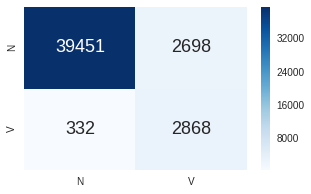

In [26]:
print_confusion_matrix(y_true_test, y_pred_test)

In [27]:
print_scores(y_true_test, y_pred_test)

              precision    recall  f1-score   support

           N       0.99      0.94      0.96     42149
           V       0.52      0.90      0.65      3200

   micro avg       0.93      0.93      0.93     45349
   macro avg       0.75      0.92      0.81     45349
weighted avg       0.96      0.93      0.94     45349

accuracy:  0.933184855233853


## 精度向上に向けて

### クラス不均衡データへの対応

* 予測スコア(Accuracy)は高かったが、単に全てのデータを'N'と予測してもTestで90.88%の精度が出ることになる.
* クラス不均衡なデータで学習させると、大多数を占めるラベルに予測結果が偏ってしまう傾向にある => S、Vに対する予測精度が低い理由
* こうした不均衡データの問題を解消するための方法として代表的な方法が幾つかあある
    * Undersampling / Oversampling
    * 損失関数の変更


#### Undersampling & Oversampling (SMOTE)




In [0]:
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import SMOTE


class SampledECGDataset(ECGDataset):

    def __init__(
            self,
            path
    ):
        super(SampledECGDataset, self).__init__(path)
        _, counts = np.unique(self.y, return_counts=True)
        self.X, self.y = make_imbalance(
            self.X, self.y,
            sampling_strategy={0: counts[0]//5, 1: counts[1]}
        )
        smote = SMOTE(random_state=42)
        self.X, self.y = smote.fit_sample(self.X, self.y)

        
def create_sampled_datasets(root_path):
    train_path = os.path.join(root_path, "train")
    validation_path = os.path.join(root_path, "validation")
    train_dataset = SampledECGDataset(train_path)

    return train_dataset

In [0]:
train_dataset = create_sampled_datasets(dataset_root)

In [0]:
trainer = create_trainer(256, train_dataset, nb_epoch=2, device=0)

In [32]:
%time trainer.run()

epoch       iteration   main/loss   main/accuracy
0           7           1.5549      0.637277       
0           14          0.372147    0.833705       
0           21          0.209371    0.930804       
0           28          0.124632    0.957031       
0           35          0.0814286   0.96875        
0           42          0.0648148   0.977121       
0           49          0.0588549   0.978237       
0           56          0.0446123   0.985491       
0           63          0.0515078   0.982143       
1           70          0.0391871   0.985491       
1           77          0.0254058   0.99442        
1           84          0.0205729   0.992746       
1           91          0.0235527   0.992188       
1           98          0.0172338   0.994978       
1           105         0.0166827   0.99442        
1           112         0.0138582   0.997768       
1           119         0.0162967   0.994978       
1           126         0.0157962   0.996094       
1           13

In [33]:
%time y_true_test, y_pred_test = evaluate(trainer, test_dataset, 256, 0)

CPU times: user 14.8 s, sys: 2.49 s, total: 17.3 s
Wall time: 17.3 s


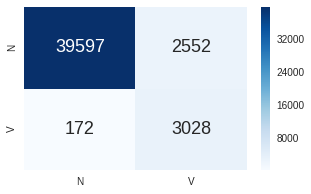

In [34]:
print_confusion_matrix(y_true_test, y_pred_test)

In [35]:
print_scores(y_true_test, y_pred_test)

              precision    recall  f1-score   support

           N       1.00      0.94      0.97     42149
           V       0.54      0.95      0.69      3200

   micro avg       0.94      0.94      0.94     45349
   macro avg       0.77      0.94      0.83     45349
weighted avg       0.96      0.94      0.95     45349

accuracy:  0.939932523319147


#### 損失関数の変更

TODO: コード - 動かないので動くようにする

In [0]:
from chainer.backends.cuda import get_array_module

def focal_loss(x, t, class_num=2, gamma=2., eps=1e-6):
    xp = get_array_module(t)

    p = F.softmax(x)
    p = F.clip(p, x_min=eps, x_max=1-eps)
    log_p = F.log_softmax(x)
    t_onehot = xp.eye(class_num)[t]

    loss_sce = -1 * t_onehot * log_p
    loss_focal = F.sum(loss_sce * (1. - p) ** gamma, axis=1)

    return F.mean(loss_focal)

In [0]:
train_dataset = create_datasets(dataset_root)

In [0]:
trainer = create_trainer(256, train_dataset, nb_epoch=1, device=0, lossfun=focal_loss)

In [39]:
%time trainer.run()

epoch       iteration   main/loss   main/accuracy
0           7           1.53746     0.806362       
0           14          0.287601    0.875          
0           21          0.0698186   0.93192        
0           28          0.0438095   0.944196       
0           35          0.0550418   0.929688       
0           42          0.0330854   0.955915       
0           49          0.0310767   0.96875        
0           56          0.0150656   0.981027       
0           63          0.0246014   0.970982       
0           70          0.0157674   0.978795       
0           77          0.0155997   0.979353       
0           84          0.01527     0.982701       
0           91          0.0136532   0.980469       
0           98          0.0389695   0.987723       
0           105         0.0109694   0.984375       
0           112         0.00979762  0.987723       
0           119         0.0145389   0.982143       
0           126         0.0107648   0.988281       
0           13

In [40]:
%time y_true_test, y_pred_test = evaluate(trainer, test_dataset, 256, 0)

CPU times: user 14.8 s, sys: 2.55 s, total: 17.4 s
Wall time: 17.4 s


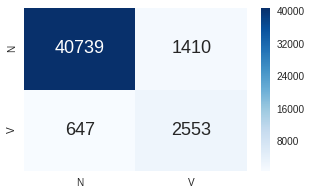

In [41]:
print_confusion_matrix(y_true_test, y_pred_test)

In [42]:
print_scores(y_true_test, y_pred_test)

              precision    recall  f1-score   support

           N       0.98      0.97      0.98     42149
           V       0.64      0.80      0.71      3200

   micro avg       0.95      0.95      0.95     45349
   macro avg       0.81      0.88      0.84     45349
weighted avg       0.96      0.95      0.96     45349

accuracy:  0.9546406756488567


### 特徴抽出方法の変更

#### ネットワーク構造の変更

In [0]:
class DilatedResNet34(chainer.Chain):

    def __init__(self):
        super(DilatedResNet34, self).__init__()
        with self.init_scope():
            self.conv1 = L.ConvolutionND(1, None, 64, 7, 2, 3)
            self.bn1 = L.BatchNormalization(64)
            self.resblock0 = ResBlockBase(64, 3, 1)
            self.resblock1 = ResBlockBase(128, 4, 1)
            self.resblock2 = ResBlockBase(256, 6, 2)
            self.resblock3 = ResBlockBase(512, 3, 4)
            self.fc1 = L.Linear(None, 512)
            self.fc2 = L.Linear(None, 2)

    def __call__(self, x):
        h = F.relu(self.bn1(self.conv1(x)))
        h = F.max_pooling_nd(h, 3, 2)
        for i in range(4):
            h = getattr(self, 'resblock{}'.format(str(i)))(h)
        h = F.average(h, axis=2)
        h = F.dropout(self.fc1(h), 0.5)
        h = self.fc2(h)
        return h
      

In [0]:
def create_trainer(
    batchsize, train_dataset, nb_epoch=1,
    device=0, lossfun=F.softmax_cross_entropy
):
    # setup model
    model = DilatedResNet34()
    train_model = Classifier(model, lossfun=lossfun)

    # use Adam optimizer
    optimizer = optimizers.Adam(alpha=0.001)
    optimizer.setup(train_model)
    optimizer.add_hook(WeightDecay(0.0001))

    # setup iterator
    train_iter = MultiprocessIterator(train_dataset, batchsize)

    # define updater
    updater = training.StandardUpdater(train_iter, optimizer, device=device)

    # setup trainer
    stop_trigger = (nb_epoch, 'epoch')
    trainer = training.trainer.Trainer(updater, stop_trigger)
    logging_attributes = [
        'epoch', 'iteration',
        'main/loss', 'main/accuracy'        
    ]
    trainer.extend(
        extensions.LogReport(logging_attributes, trigger=(2000 // batchsize, 'iteration'))
    )
    trainer.extend(
        extensions.PrintReport(logging_attributes)
    )
    trainer.extend(
        extensions.ExponentialShift('alpha', 0.75, optimizer=optimizer),
        trigger=(4000 // batchsize, 'iteration')
    )

    return trainer

In [0]:
train_dataset = create_datasets(dataset_root)
test_dataset = create_test_dataset(dataset_root)

In [0]:
trainer = create_trainer(256, train_dataset, nb_epoch=1, device=0)

In [47]:
%time trainer.run()

epoch       iteration   main/loss   main/accuracy
0           7           0.984993    0.820871       
0           14          0.271389    0.917969       
0           21          0.238406    0.919643       
0           28          0.187035    0.919643       
0           35          0.147569    0.93471        
0           42          0.220239    0.967634       
0           49          0.279385    0.969866       
0           56          0.0845302   0.969866       
0           63          0.0495845   0.983259       
0           70          0.0635208   0.981027       
0           77          0.0484835   0.984933       
0           84          0.0485552   0.985491       
0           91          0.0375603   0.987723       
0           98          0.0417249   0.987723       
0           105         0.0444891   0.988281       
0           112         0.035503    0.989397       
0           119         0.0267511   0.990513       
0           126         0.0471523   0.994978       
0           13

- TODO: 説明 - validationセットの評価

- TODO: 説明文 - テストセットの評価

In [48]:
%time y_true_test, y_pred_test = evaluate(trainer, test_dataset, 256, 0)

CPU times: user 14.7 s, sys: 2.38 s, total: 17.1 s
Wall time: 17.1 s


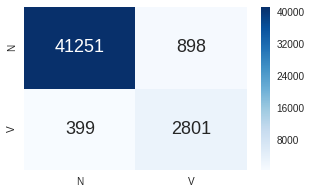

In [49]:
print_confusion_matrix(y_true_test, y_pred_test)

In [50]:
print_scores(y_true_test, y_pred_test)

              precision    recall  f1-score   support

           N       0.99      0.98      0.98     42149
           V       0.76      0.88      0.81      3200

   micro avg       0.97      0.97      0.97     45349
   macro avg       0.87      0.93      0.90     45349
weighted avg       0.97      0.97      0.97     45349

accuracy:  0.9713995898476262


### ノイズ除去の効果検証

- TODO: 説明 - 心電図波形には高周波ノイズ(筋電図ノイズ(Electromyogram noise)、加算性白色ガウスノイズ(Additive white Gaussian noise)力線妨害(power line interference))と、低周波ノイズ(基線変動ノイズ(baseline wandering))が含まれているため, 徐脈などの異常波形をうまく判別するために, 不要なノイズを除去する前処理を行うのが通例である
- TODO: 説明 - ノイズフィルタリングについて簡単に説明する
- TODO: MIT-BIHデータセットでは、≧0.1Hz & ≦100Hzのband-pass filterが既に適用されているが、それよりも厳しめのフィルタリングを行い, その効果を検証する(https://www.physionet.org/physiobank/database/html/mitdbdir/intro.htm#selection)



- Pros: ノイズを除くことで徐脈などの異常波形パターンを特徴として捉えやすくなる可能性がある
- Cons: 波形に含まれている重要な情報が, フィルタリングによって失われる可能性がある

In [0]:
from scipy.signal import butter, lfilter, medfilt


class DenoiseECGDatasetPreprocessor(BaseECGDatasetPreprocessor):

    def __init__(
            self,
            dataset_root='./',
            window_size=720
    ):
        super(DenoiseECGDatasetPreprocessor, self).__init__(
        dataset_root, window_size)

    def denoise_signal(
            self,
            signal,
            cutoff_low=0.2,
            cutoff_high=30.,
            order=5
    ):
        nyquist = self.sample_rate / 2.
        if cutoff_low <= 0.5 and cutoff_high >= 2.5:
            cut_off = (cutoff_low / nyquist, cutoff_high / nyquist)
            b, a = butter(order, cut_off, analog=False, btype='band')
        elif cutoff_low <= 0.5:
            cut_off = cutoff_low / nyquist
            b, a = butter(order, cut_off, analog=False, btype='high')
        elif cutoff_high >= 2.5:
            cut_off = cutoff_high / nyquist
            b, a = butter(order, cut_off, analog=False, btype='low')
        else:
            return signal
        return lfilter(b, a, signal)

    def create_data_slices(
            self,
            signal,
            symbols,
            positions
    ):
        X = []
        y = []
        sig_len = len(signal)
        for i in range(len(symbols)):
            start = positions[i] - self.window_size // 2
            end = positions[i] + self.window_size // 2
            if symbols[i] in self.valid_symbols and start >= 0 and end <= sig_len:
                segment = signal[start:end]
                assert len(segment) == self.window_size, "Invalid length"
                X.append(segment)
                y.append(self.labels.index(self.label_map[symbols[i]]))
        return np.array(X), np.array(y)

    def prepare_dataset(
            self,
            denoise=False,
            normalize=True
    ):
        if not os.path.isdir(self.download_dir):
            self.download_data()

        # prepare training dataset
        self._prepare_dataset_core(self.train_record_list, "train", denoise, normalize)
        # prepare test dataset
        self._prepare_dataset_core(self.test_record_list, "test", denoise, normalize)

    def _prepare_dataset_core(
            self,
            record_list,
            mode="train",
            denoise=False,
            normalize=True
    ):
        X, y = None, None
        for i in range(len(record_list)):
            signal, symbols, positions = self.load_data(record_list[i])
            if denoise:
                signal = self.denoise_signal(signal)
            if normalize:
                signal = self.normalize_signal(signal)
            if i == 0:
                X, y = self.create_data_slices(signal, symbols, positions)
            else:
                X_tmp, y_tmp = self.create_data_slices(signal, symbols, positions)
                X = np.vstack((X, X_tmp))
                y = np.concatenate((y, y_tmp))
        os.makedirs(os.path.join(self.dataset_root, mode), exist_ok=True)
        np.save(os.path.join(self.dataset_root, mode, "X.npy"), X)
        np.save(os.path.join(self.dataset_root, mode, "y.npy"), y)


In [0]:
d_preprocessor = DenoiseECGDatasetPreprocessor(dataset_root)

TODO: 説明 - 5次のButterworth filter (band-pass)を適用してノイズ除去を行う

In [0]:
d_preprocessor.prepare_dataset(denoise=True)

In [0]:
X_train_d = np.load(os.path.join(dataset_root, 'train', 'X.npy'))
y_train_d = np.load(os.path.join(dataset_root, 'train', 'y.npy'))

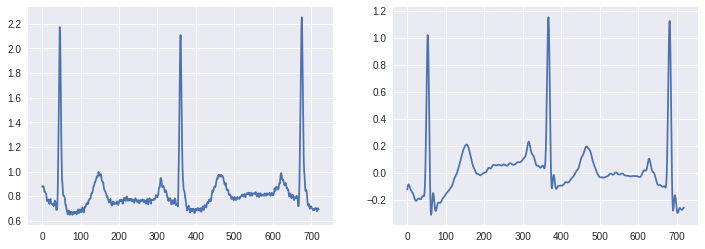

In [58]:
plt.subplots(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(X_train[idx_n[0]])
plt.subplot(1, 2, 2)
plt.plot(X_train_d[idx_n[0]])
plt.show()

左図がフィルタリング前、右図がフィルタリング後

In [0]:
train_dataset = create_datasets(dataset_root)
test_dataset = create_test_dataset(dataset_root)

In [60]:
trainer = create_trainer(256, train_dataset, nb_epoch=1, device=0)
trainer.run()

epoch       iteration   main/loss   main/accuracy
0           7           0.943153    0.905134       
0           14          0.281551    0.955357       
0           21          0.121105    0.958705       
0           28          0.114655    0.969308       
0           35          0.0611682   0.978795       
0           42          0.0549055   0.985491       
0           49          0.0551493   0.985491       
0           56          0.0432593   0.989397       
0           63          0.0180693   0.993862       
0           70          0.0263636   0.991071       
0           77          0.0160459   0.993862       
0           84          0.0230151   0.993304       
0           91          0.0140904   0.995536       
0           98          0.0230149   0.991071       
0           105         0.0100289   0.996094       
0           112         0.0459271   0.992188       
0           119         0.0229435   0.996094       
0           126         0.0124526   0.995536       
0           13

In [61]:
%time y_true_test, y_pred_test = evaluate(trainer, test_dataset, 256, 0)

CPU times: user 15 s, sys: 2.26 s, total: 17.3 s
Wall time: 17.3 s


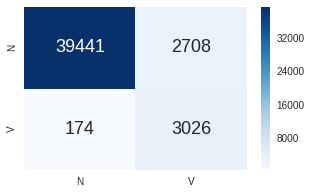

In [62]:
print_confusion_matrix(y_true_test, y_pred_test)

In [63]:
print_scores(y_true_test, y_pred_test)

              precision    recall  f1-score   support

           N       1.00      0.94      0.96     42149
           V       0.53      0.95      0.68      3200

   micro avg       0.94      0.94      0.94     45349
   macro avg       0.76      0.94      0.82     45349
weighted avg       0.96      0.94      0.94     45349

accuracy:  0.9364484332620344
